In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import seaborn as sns

### Function to Read and Load .cfile Data

In [2]:
def getData(cfileName):
    """
    Given a name of a *.cfile, this function extracts the interleaved
    Inphase-Quadrature data samples and convert it into a numpy array of complex
    data elements. *.cfile format has interleaved I and Q samples where each sample
    is a float32 type. GNURadio Companion (GRC) scripts output data into a file
    though a file sink block in this format.
    Read more in SDR data types: https://github.com/miek/inspectrum
    """
    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")
    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

### Calculate IQ Magnitude

In [3]:
def calculate_IQMagnitude(complex_data):
    # Separate I and Q data
    I = np.real(complex_data)
    Q = np.imag(complex_data)
    
    # Calculate RSSI for each sample
    magnitude = np.sqrt(I**2 + Q**2)
    
    return magnitude

### Calculate IQ Angle

In [4]:
def calculate_IQ_Angle(complex_data):
    I = np.real(complex_data)
    Q = np.imag(complex_data)
    
    # Calculate RSSI for each sample
    angle = np.arctan(Q/I)
    return angle
    

### Trunacate Vectors

In [5]:
def truncate_vectors_to_same_size(*vectors):
    # Find the minimum length among all vectors
    min_length = min(len(vec) for vec in vectors)
    # Truncate all vectors to the same length
    return [vec[:min_length] for vec in vectors]

### Sanitize Vectors

In [6]:
def sanitize_vector(vector):
    # Replace NaN or Inf values with zeros or a suitable value
    vector = np.nan_to_num(vector, nan=0.0, posinf=0.0, neginf=0.0)
    return vector

### Reading Data

In [7]:
dataWithOutInterference = getData("./NoInterference.cfile")

In [8]:
dataWithInterferenceLOSCenter = getData("./LosCenter.cfile")
dataWithInterferenceLOSFirstQuartile = getData("./LosFirstQuartile.cfile")
dataWithInterferenceLOSThirdQuartile = getData("./LosThirdQuartile.cfile")

In [9]:
dataWithInterferenceNLOSLeftCenter = getData("./NLosLeftCenter.cfile")
dataWithInterferenceNLOSLeftFirstQuartile = getData("./NLosLeftFirstQuartile.cfile")
dataWithInterferenceNLOSLeftThirdQuartile = getData("./NLosLeftThirdQuartile.cfile")

In [10]:
dataWithInterferenceNLOSRightCenter = getData("./NLosRightCenter.cfile")
dataWithInterferenceNLOSRightFirstQuartile = getData("./NLosRightFirstQuartile.cfile")
dataWithInterferenceNLOSRightThirdQuartile = getData("./NLosRightThirdQuartile.cfile")

### Amplitude Vector

In [11]:
Amplitude_Vectors_Raw = [
    calculate_IQMagnitude(dataWithInterferenceNLOSLeftFirstQuartile),
    calculate_IQMagnitude(dataWithInterferenceNLOSLeftCenter),
    calculate_IQMagnitude(dataWithInterferenceNLOSLeftThirdQuartile),
    calculate_IQMagnitude(dataWithInterferenceLOSFirstQuartile),
    calculate_IQMagnitude(dataWithInterferenceLOSCenter),
    calculate_IQMagnitude(dataWithInterferenceLOSThirdQuartile),
    calculate_IQMagnitude(dataWithInterferenceNLOSRightFirstQuartile),
    calculate_IQMagnitude(dataWithInterferenceNLOSRightCenter),
    calculate_IQMagnitude(dataWithInterferenceNLOSRightThirdQuartile),
]

In [12]:
Amplitude_Vectors = truncate_vectors_to_same_size(*Amplitude_Vectors_Raw)

# Map back truncated vectors to their variables
(
    amplitude_NLOSLeftFirstQuartile,
    amplitude_NLOSLeftCenter,
    amplitude_NLOSLeftThirdQuartile,
    amplitude_LOSFirstQuartile,
    amplitude_LOSCenter,
    amplitude_LOSThirdQuartile,
    amplitude_NLOSRightFirstQuartile,
    amplitude_NLOSRightCenter,
    amplitude_NLOSRightThirdQuartile,
) = Amplitude_Vectors

In [13]:
Amplitude_Vector_Eucleidian_LOSFirstQuartile = np.array([
    [
        distance.euclidean(amplitude_NLOSLeftFirstQuartile, amplitude_LOSFirstQuartile),
        distance.euclidean(amplitude_NLOSLeftCenter, amplitude_LOSFirstQuartile),
        distance.euclidean(amplitude_NLOSLeftThirdQuartile, amplitude_LOSFirstQuartile),
    ],
    [
        distance.euclidean(amplitude_LOSFirstQuartile, amplitude_LOSFirstQuartile),
        distance.euclidean(amplitude_LOSCenter, amplitude_LOSFirstQuartile),
        distance.euclidean(amplitude_LOSThirdQuartile, amplitude_LOSFirstQuartile),
    ],
    [
        distance.euclidean(amplitude_NLOSRightFirstQuartile, amplitude_LOSFirstQuartile),
        distance.euclidean(amplitude_NLOSRightCenter, amplitude_LOSFirstQuartile),
        distance.euclidean(amplitude_NLOSRightThirdQuartile, amplitude_LOSFirstQuartile),
    ],
])

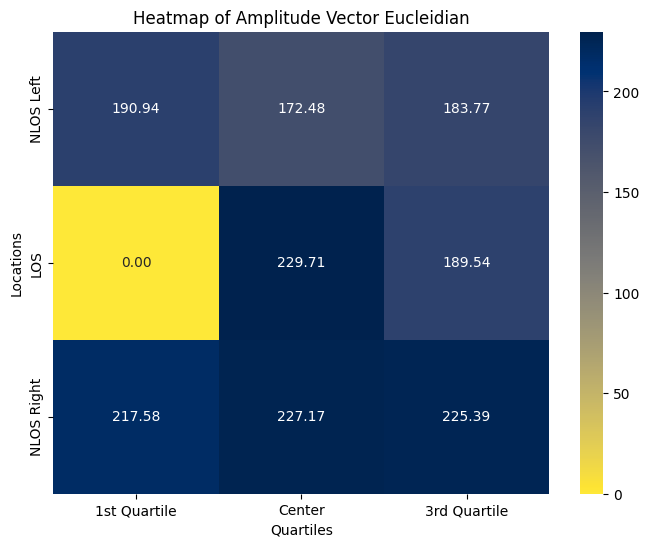

In [14]:
# Create a heatmap with reversed colormap
plt.figure(figsize=(8, 6))
sns.heatmap(
    Amplitude_Vector_Eucleidian_LOSFirstQuartile, 
    annot=True, 
    cmap="cividis_r",  # Reversed colormap for yellow closer to 0
    fmt=".2f",
    xticklabels=["1st Quartile", "Center", "3rd Quartile"],
    yticklabels=["NLOS Left", "LOS", "NLOS Right"]
)
plt.title("Heatmap of Amplitude Vector Eucleidian")
plt.xlabel("Quartiles")
plt.ylabel("Locations")
plt.show()

### Phasse Vector

In [15]:
Phase_Vectors_Raw = [
    sanitize_vector(calculate_IQ_Angle(dataWithInterferenceNLOSLeftFirstQuartile)),
    sanitize_vector(calculate_IQ_Angle(dataWithInterferenceNLOSLeftCenter)),
    sanitize_vector(calculate_IQ_Angle(dataWithInterferenceNLOSLeftThirdQuartile)),
    sanitize_vector(calculate_IQ_Angle(dataWithInterferenceLOSFirstQuartile)),
    sanitize_vector(calculate_IQ_Angle(dataWithInterferenceLOSCenter)),
    sanitize_vector(calculate_IQ_Angle(dataWithInterferenceLOSThirdQuartile)),
    sanitize_vector(calculate_IQ_Angle(dataWithInterferenceNLOSRightFirstQuartile)),
    sanitize_vector(calculate_IQ_Angle(dataWithInterferenceNLOSRightCenter)),
    sanitize_vector(calculate_IQ_Angle(dataWithInterferenceNLOSRightThirdQuartile)),
]

C:\Users\Deelaka Algawatta\AppData\Local\Temp\ipykernel_18792\2377027175.py:6: RuntimeWarning: divide by zero encountered in divide
  angle = np.arctan(Q/I)
C:\Users\Deelaka Algawatta\AppData\Local\Temp\ipykernel_18792\2377027175.py:6: RuntimeWarning: invalid value encountered in divide
  angle = np.arctan(Q/I)


In [16]:
Phase_Vectors = truncate_vectors_to_same_size(*Phase_Vectors_Raw)

# Map back truncated vectors to their variables
(
    phase_NLOSLeftFirstQuartile,
    phase_NLOSLeftCenter,
    phase_NLOSLeftThirdQuartile,
    phase_LOSFirstQuartile,
    phase_LOSCenter,
    phase_LOSThirdQuartile,
    phase_NLOSRightFirstQuartile,
    phase_NLOSRightCenter,
    phase_NLOSRightThirdQuartile,
) = Phase_Vectors

In [17]:
Phase_Vector_Euclidean_LOSFirstQuartile = np.array([
    [
        distance.euclidean(phase_NLOSLeftFirstQuartile, phase_LOSFirstQuartile),
        distance.euclidean(phase_NLOSLeftCenter, phase_LOSFirstQuartile),
        distance.euclidean(phase_NLOSLeftThirdQuartile, phase_LOSFirstQuartile),
    ],
    [
        distance.euclidean(phase_LOSFirstQuartile, phase_LOSFirstQuartile),
        distance.euclidean(phase_LOSCenter, phase_LOSFirstQuartile),
        distance.euclidean(phase_LOSThirdQuartile, phase_LOSFirstQuartile),
    ],
    [
        distance.euclidean(phase_NLOSRightFirstQuartile, phase_LOSFirstQuartile),
        distance.euclidean(phase_NLOSRightCenter, phase_LOSFirstQuartile),
        distance.euclidean(phase_NLOSRightThirdQuartile, phase_LOSFirstQuartile),
    ],
])

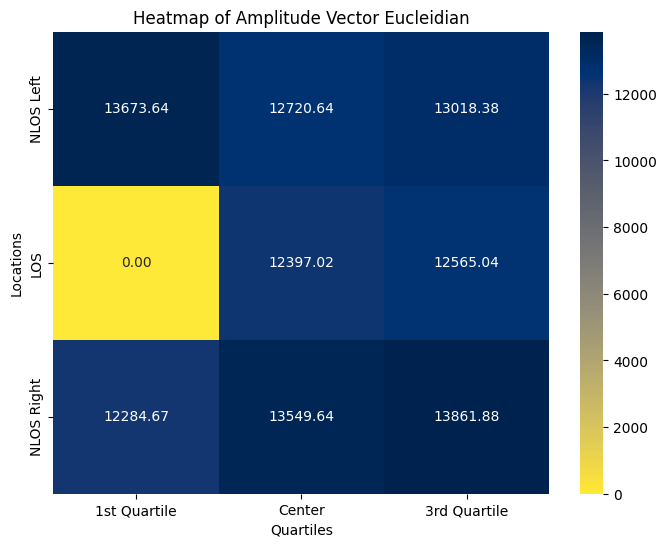

In [18]:
# Create a heatmap with reversed colormap
plt.figure(figsize=(8, 6))
sns.heatmap(
    Phase_Vector_Euclidean_LOSFirstQuartile, 
    annot=True, 
    cmap="cividis_r",  # Reversed colormap for yellow closer to 0
    fmt=".2f",
    xticklabels=["1st Quartile", "Center", "3rd Quartile"],
    yticklabels=["NLOS Left", "LOS", "NLOS Right"]
)
plt.title("Heatmap of Amplitude Vector Eucleidian")
plt.xlabel("Quartiles")
plt.ylabel("Locations")
plt.show()

### Heat map layered

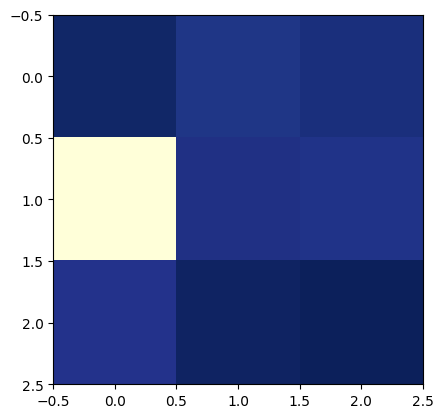

In [19]:
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt

cmap_name = 'yellow_to_blue'
n_bins = 100
colors = [(1, 1, 0), (0, 0, 1)]
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the first heatmap with full opacity (alpha = 1)
ax.imshow(Amplitude_Vector_Eucleidian_LOSFirstQuartile, cmap='YlGnBu', interpolation='nearest', alpha=0.9)

# Plot the second heatmap with reduced opacity (alpha = 0.7)
ax.imshow(Phase_Vector_Euclidean_LOSFirstQuartile, cmap='YlGnBu', interpolation='nearest', alpha=0.7)
ax.imshow(Phase_Vector_Euclidean_LOSFirstQuartile, cmap='YlGnBu', interpolation='nearest', alpha=0.5)
# Show the plot
plt.show()